# Text Classification Exam

Welcome to the Text Classification Practical Exam. In this exam, you will be tasked with building, training, and evaluating an NLP model to classify text data. You are provided with a labeled dataset containing both the text and its corresponding class labels.

Your objective is to develop a model that accurately predicts the class of the given text. Make sure to follow best practices in data preprocessing, model selection, and evaluation to achieve optimal results.

Good luck!
___

# Install and Import Needed Libraries

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Download the Dataset

In [2]:
!kaggle datasets download -d khaledzsa/spam-messages
!unzip spam-messages.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/spam-messages
License(s): unknown
  0% 0.00/213k [00:00<?, ?B/s]
100% 213k/213k [00:00<00:00, 38.0MB/s]
Archive:  spam-messages.zip
  inflating: spam.csv                


In [3]:
df = pd.read_csv('spam.csv')
df.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


# Data Exploration

Before diving into preprocessing and model building, it’s important to first explore the dataset to understand its structure, distribution, and key characteristics. This step will help you gain insights into the data and guide your decisions in subsequent steps. Here’s what to consider:

1. **Inspect the Data**:
   Start by looking at the first few rows of the dataset to get a sense of its structure. Check the columns, data types, and a few sample entries. This helps to ensure that the data is loaded correctly and gives you an initial overview of the content.

2. **Check for Missing Values**:
   Identify if there are any missing values in the dataset.

3. **Distribution of Labels**:
   Examine the distribution of the target labels (classes).

4. **Text Data Characteristics (Bonus)**:
   Analyze the length of the text data. It is useful to calculate the number of words or characters in each text sample to understand how long the texts are. This will help you set a suitable `max_length` for tokenization and padding later. You can plot a histogram of text lengths to visualize the distribution.

5. **Common Words and Vocabulary (Bonus)**:
   Explore the most frequent words in the text data.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5572 non-null   object
 1   label   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
df.describe()

,text,label
count,5572,5572
unique,5389,2
top,"Sorry, I'll call later",ham
freq,16,4825


In [6]:
df.isnull().sum()

,0
text,0
label,0


In [7]:
print("\nUnique labels in the dataset:")
print(df['label'].unique())


Unique labels in the dataset:
['ham' 'spam']



Distribution of target labels:
label
ham     4825
spam     747
Name: count, dtype: int64


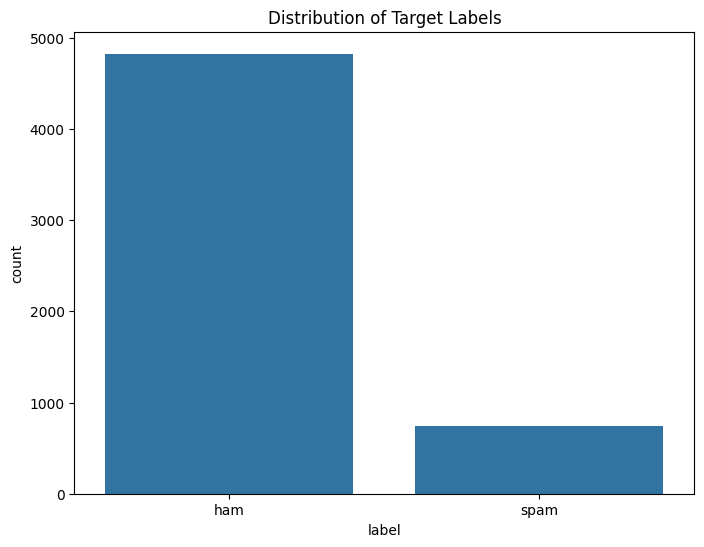

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check the distribution of target labels (assuming the label column is 'label')
print("\nDistribution of target labels:")
print(df['label'].value_counts())

# Plot the distribution of labels
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Target Labels')
plt.show()


In [9]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.9 MB/s eta 0:00:00


In [10]:
import nlpaug


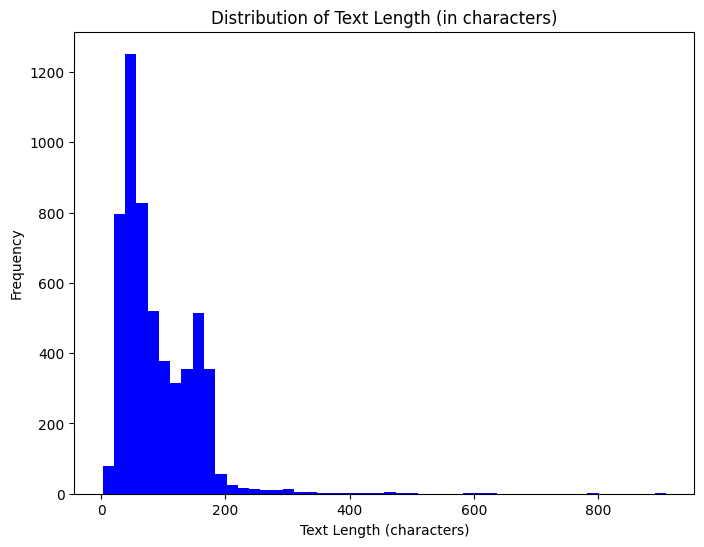


Average number of words per sample: 15.994077530509692


In [11]:
df['text_length'] = df['text'].apply(len)


plt.figure(figsize=(8, 6))
plt.hist(df['text_length'], bins=50, color='blue')
plt.title('Distribution of Text Length (in characters)')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.show()

# Optionally, calculate the number of words
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
print("\nAverage number of words per sample:", df['word_count'].mean())

In [12]:
from collections import Counter


all_words = ' '.join(df['text'])


word_counts = Counter(all_words.split())


print("\n10 Most common words:")
print(word_counts.most_common(20))



10 Most common words:
[('to', 2134), ('you', 1622), ('I', 1466), ('a', 1327), ('the', 1197), ('https://link1.com', 958), ('https://link3.com', 916), ('https://link2.com', 910), ('and', 857), ('in', 798), ('is', 781), ('i', 742), ('u', 692), ('for', 644), ('my', 628), ('of', 591), ('your', 560), ('me', 557), ('on', 487), ('have', 474)]


In [13]:
## There no missing words

In [14]:
df.shape

(5572, 4)

In [15]:
min_words = 3
max_words = 100

df['word_count'] = df['text'].apply(lambda x: len(x.split()))
filtered_df = df[(df['word_count'] >= min_words) & (df['word_count'] <= max_words)]
print("\nNumber of samples after filtering:", len(filtered_df))


Number of samples after filtering: 5506


In [16]:
from nltk.corpus import names, stopwords, words
import nltk
nltk.download('stopwords')
eng_stopwords = set(stopwords.words('english'))

def remove_stopwords(text):
  return ' '.join([word for word in text.split() if word not in eng_stopwords])

filtered_df['text'] = filtered_df['text'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-16-084fe4e76ae8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['text'] = filtered_df['text'].apply(remove_stopwords)


In [17]:
import re

from nltk.stem.isri import ISRIStemmer

stemmer = ISRIStemmer()


def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text)


def remove_special_chars(text):
    return re.sub(r'[^\w\s]', '', text)



def stem_text(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

# Full text cleaning function
def clean_text(text):
    text = remove_urls(text)
    text = remove_special_chars(text)
    text = stem_text(text)
    return text

# Apply the cleaning function to the text column
filtered_df['cleaned_text'] = filtered_df['text'].apply(clean_text)

# View the first 5 cleaned rows
print(filtered_df[['text', 'cleaned_text']].head())


                                                text  \
0  Go jurong point, crazy.. Available bugis n gre...   
1                      Ok lar... Joking wif u oni...   
2  Free entry 2 wkly comp win FA Cup final tkts 2...   
3  U dun say early hor... U c already say... http...   
4  Nah I think goes usf, lives around though http...   

                                        cleaned_text  
0  Go jurong point crazy Available bugis n great ...  
1                            Ok lar Joking wif u oni  
2  Free entry 2 wkly comp win FA Cup final tkts 2...  
3                U dun say early hor U c already say  
4           Nah I think goes usf lives around though  


<ipython-input-17-b61eec01635a>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cleaned_text'] = filtered_df['text'].apply(clean_text)


In [18]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5506 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          5506 non-null   object
 1   label         5506 non-null   object
 2   text_length   5506 non-null   int64 
 3   word_count    5506 non-null   int64 
 4   cleaned_text  5506 non-null   object
dtypes: int64(2), object(3)
memory usage: 258.1+ KB


In [27]:
import nlpaug.augmenter.word as naw
from collections import Counter


print("Class Distribution Before Augmentation:")
print(filtered_df['label'].value_counts())


aug = naw.SynonymAug(aug_src='wordnet')


def augment_text(text, augmenter, n_augments=5):
    augmented_texts = [augmenter.augment(text) for _ in range(n_augments)]
    return augmented_texts


minority_class = filtered_df['label'].value_counts().idxmin()


minority_samples = filtered_df[filtered_df['label'] == minority_class]


augmented_texts = []
augmented_labels = []

for text in minority_samples['cleaned_text']:
    augmented_samples = augment_text(text, aug)
    augmented_texts.extend(augmented_samples)
    augmented_labels.extend([minority_class] * len(augmented_samples))


augmented_df = pd.DataFrame({
    'cleaned_text': augmented_texts,
    'label': augmented_labels
})


balanced_df = pd.concat([filtered_df, augmented_df])


print("Class Distribution After Augmentation:")
print(balanced_df['label'].value_counts())




Class Distribution Before Augmentation:
label
ham     4759
spam     747
Name: count, dtype: int64


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Class Distribution After Augmentation:
label
ham     4759
spam    4482
Name: count, dtype: int64



Distribution of target labels:
label
ham     4825
spam     747
Name: count, dtype: int64


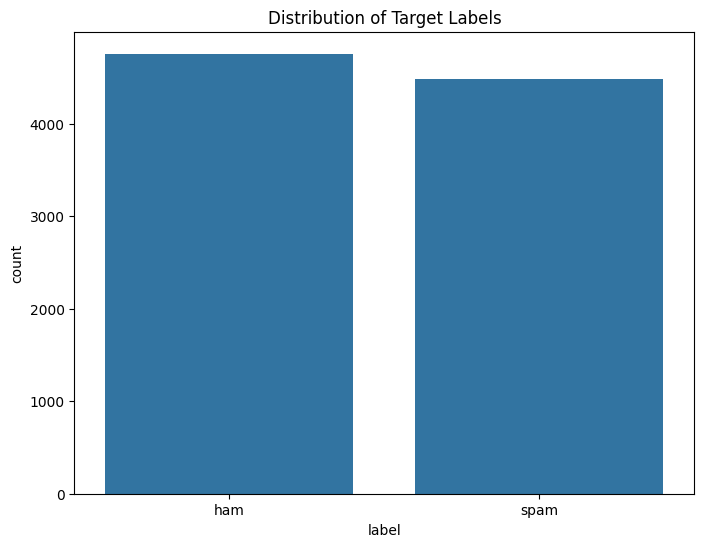

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check the distribution of target labels (assuming the label column is 'label')
print("\nDistribution of target labels:")
print(df['label'].value_counts())

# Plot the distribution of labels
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=balanced_df)
plt.title('Distribution of Target Labels')
plt.show()


# Data Cleaning and Preprocessing

In this section, we will focus on cleaning and filtering the dataset, preparing it for the text classification task. We will implement the following steps:

1. **Remove missing values**:  
   First, we eliminate any rows with missing values to ensure the dataset is complete and consistent.

2. **Filter by text length (Bonus)**:  
   To maintain a uniform dataset, we will filter the text samples by a specified word count range. This ensures that the texts are neither too short to lack context nor too long to introduce unnecessary complexity.

3. **English stopwords loading**:  
   We load a list of English stopwords to filter out commonly used but contextually insignificant words. This is an important step for improving the performance of the model, as stopwords do not contribute valuable information.

4. **Text cleaning**:  
   We apply a series of text cleaning steps to standardize and simplify the text data. This involves:
   
   - **Removing links (URLs)**:  
     Any URLs present in the text are removed as they are not meaningful for classification purposes.
   
   - **Removing special characters and punctuation**:  
     This step removes any non-alphabetical characters, ensuring the text only contains meaningful words.
   
   - **Lowercasing**:  
     All text is converted to lowercase for uniformity and to avoid case sensitivity issues.
   
   - **Removing English stopwords**:  
     Words that are part of the stopwords list are removed, as they do not add value to the classification task.
   
   - **Stemming or Lemmatization**:  
     Either stemming or lemmatization is applied to reduce words to their root or base form, ensuring consistency in word forms.

5. **Final cleanup**:
   Apply the cleanup function to the feature column.

By following these steps, the text will be cleaned, filtered, and ready for tokenization!

# Tokenization, Padding, and Data Splitting

In this step, we will prepare the text data for input into a model by converting the text into numerical sequences, padding them to a uniform length, and splitting the dataset into training and testing sets. Here's an overview of the steps involved:

1. **Tokenization**:
   We use a tokenizer to convert the cleaned text into numerical sequences. You can use `Tokenizer` tokenizer from `tensorflow.keras.preprocessing.text` package or any other tokenizer you like.

2. **Text to sequences**:
   After fitting the tokenizer on the cleaned text, we transform each text into a sequence of numbers, where each number corresponds to a token (word) in the text.

3. **Padding the sequences**:
   Since different texts may vary in length, we pad the sequences to ensure they all have the same length.

4. **Label encoding**:
   The labels (target values) also need to be converted into numerical form if they are not encoded.

5. **Train-test split**:
   The dataset is divided into training and testing sets. We allocate 80% of the data for training the model and reserve 20% for testing its performance.
   
   - The **training data** consists of the padded sequences used to train the model.
   - The **training labels** are the encoded labels corresponding to the training data.
   - The **testing data** is used to assess the model’s performance after training.
   - The **testing labels** are the encoded labels corresponding to the testing data.

6. **Data shape confirmation**:
   After splitting the data, we print the shape (dimensions) of both the training and testing sets to confirm that the data is properly divided and formatted.

By the end of this step, the text data will be transformed into padded numerical sequences, the labels will be encoded, and the data will be split into training and testing sets for model development and evaluation.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         5572 non-null   object
 1   label        5572 non-null   object
 2   text_length  5572 non-null   int64 
 3   word_count   5572 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 174.2+ KB


In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_words = 5000

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')  # oov_token handles out-of-vocabulary words

# Fit the tokenizer on the cleaned text
tokenizer.fit_on_texts(balanced_df['cleaned_text'])

# Optional: View the word index
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")


Found 13116 unique tokens.


In [30]:

sequences = tokenizer.texts_to_sequences(balanced_df['cleaned_text'])

# Example: Print the first 5 sequences
print("Example of tokenized text sequences:")
for i in range(5):
    print(sequences[i])


Example of tokenized text sequences:
[12, 4336, 755, 671, 639, 1213, 51, 77, 316, 1214, 111, 2864, 1215, 18, 4337, 94]
[16, 274, 1363, 396, 3, 1795]
[13, 410, 6, 711, 865, 131, 1796, 1095, 579, 1797, 2179, 214, 2180, 30, 1796, 1798, 262, 410, 2865, 34, 2866, 332, 2867]
[3, 180, 104, 306, 2868, 3, 117, 101, 104]
[919, 2, 59, 411, 866, 1799, 157, 412]


In [31]:
from keras.preprocessing.sequence import pad_sequences

# Define the maximum sequence length
max_len = 100  # Adjust based on the distribution of text lengths

# Pad sequences to ensure uniform length
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Check the shape of the padded sequences
print(f"Shape of padded sequences: {padded_sequences.shape}")

# Example: Print the first padded sequence
print("Example of a padded sequence:")
print(padded_sequences[0])


Shape of padded sequences: (9241, 100)
Example of a padded sequence:
[  12 4336  755  671  639 1213   51   77  316 1214  111 2864 1215   18
 4337   94    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [32]:
from sklearn.preprocessing import LabelEncoder

labels = LabelEncoder().fit_transform(balanced_df['label'])
print("Example of encoded labels:")
print(labels[:5])





Example of encoded labels:
[0 0 1 0 0]


In [33]:
filtered_df.shape
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5506 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          5506 non-null   object
 1   label         5506 non-null   object
 2   text_length   5506 non-null   int64 
 3   word_count    5506 non-null   int64 
 4   cleaned_text  5506 non-null   object
dtypes: int64(2), object(3)
memory usage: 258.1+ KB


In [34]:
filtered_df.head()

,text,label,text_length,word_count,cleaned_text
0,"Go jurong point, crazy.. Available bugis n gre...",ham,111,20,Go jurong point crazy Available bugis n great ...
1,Ok lar... Joking wif u oni...,ham,29,6,Ok lar Joking wif u oni
2,Free entry 2 wkly comp win FA Cup final tkts 2...,spam,173,29,Free entry 2 wkly comp win FA Cup final tkts 2...
3,U dun say early hor... U c already say... http...,ham,67,12,U dun say early hor U c already say
4,"Nah I think goes usf, lives around though http...",ham,79,14,Nah I think goes usf lives around though


In [35]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels  # Ensures the split maintains the label distribution
)

# Print the number of samples in each set
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of testing samples: {X_test.shape[0]}")


Number of training samples: 7392
Number of testing samples: 1849


In [36]:

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)


print("\nFirst training sample (padded sequence):")
print(X_train[0])

print("\nFirst training label:")
print(y_train[0])


Training data shape: (7392, 100)
Training labels shape: (7392,)
Testing data shape: (1849, 100)
Testing labels shape: (1849,)

First training sample (padded sequence):
[225  11 490  12 948   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]

First training label:
0


# Building the Classifier

In this step, you will design and build a NLP Classifier model to classify text data. Below is a breakdown of the key components you'll implement, but it's up to you to decide how to configure them based on your understanding and experimentation:

1. **Model Type**:
   You will use a Sequential model, which allows you to stack layers in a linear sequence.

2. **Input Layer**:
   Define the shape of the input data. Consider the dimensions of your padded sequences and set the input shape accordingly.

3. **Embedding Layer**:
   The embedding layer will convert input tokens (integers) into dense vector representations. You will need to determine the size of the input dimension (based on your vocabulary) and the output dimension (embedding size).

4. **Bidirectional Simple RNN/LSTM Layers**:
   You can add one or more recurrent layers. Consider using Bidirectional layers to capture contextual information from both directions (forward and backward). You can chose SimpleRNN/GRU/LSTM to perform this step.

5. **Dense Layers**:
   Add one or more fully connected (Dense) layers to process the output from the RNN/GRU/LSTM layers.

6. **Output Layer**:
   The output layer should match the type of classification task you're working on. Consider using appropriate activation function with appropriate number of units.

7. **Model Summary**:
   After defining your model architecture, print a summary to review the number of layers, types of layers, and total parameters.

8. **Model Compilation**:
   Finally, compile the model by selecting an optimizer, a loss function, and metrics.

In [37]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, Bidirectional
from keras.optimizers import Adam


vocab_size = max_words
embedding_dim = 100
max_len = 100
rnn_units = 128
dense_units = 64
output_units = 1


model = Sequential()


model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))


model.add(Bidirectional(SimpleRNN(units=rnn_units, return_sequences=False)))


model.add(Dense(dense_units, activation='relu'))


model.add(Dense(output_units, activation='sigmoid'))  #

# Print the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Learning rate can be adjusted
    loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class
    metrics=['accuracy']
)


# Defining Batch Size, Creating Datasets, and Training the Model

In this step, you will define the batch size, create TensorFlow Datasets for both training and testing, and train the model. The key elements to consider are outlined below, and it is up to you to choose the specific configurations based on your preferences and experimentation:

1. **Batch Size**:
   Select a batch size for training and testing. The batch size determines how many samples will be processed together in one forward and backward pass during training.

2. **Creating Datasets**:
   Use TensorFlow’s `Dataset.from_tensor_slices()` to create datasets from the training and testing data.

3. **Batching the Datasets**:
   Batch the datasets by grouping the data into batches of the specified size.

4. **Training the Model**:
   Train the model by fitting it on the training dataset for a specified number of epochs. You will also need to provide the validation data to monitor the model’s performance on unseen data during training.

5. **Tracking Training History**:
   During training, the model’s performance metrics (such as loss and accuracy) will be tracked over the epochs, and the results will be stored in the `history` object.

In [39]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,  # Number of epochs to train
    batch_size=32,  # Batch size
    validation_data=(X_test, y_test),  # Validation data
    verbose=1  # Set to 1 to print progress during training
)


Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 33s 123ms/step - accuracy: 0.8488 - loss: 0.3682 - val_accuracy: 0.9643 - val_loss: 0.1140
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - accuracy: 0.9698 - loss: 0.0831 - val_accuracy: 0.9730 - val_loss: 0.0743
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 51s 141ms/step - accuracy: 0.9912 - loss: 0.0333 - val_accuracy: 0.9822 - val_loss: 0.0687
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 29s 89ms/step - accuracy: 0.9962 - loss: 0.0158 - val_accuracy: 0.9838 - val_loss: 0.0634
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - accuracy: 0.9974 - loss: 0.0077 - val_accuracy: 0.9832 - val_loss: 0.0684
Epoch 6/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 44s 110ms/step - accuracy: 0.9985 - loss: 0.0044 - val_accuracy: 0.9827 - val_loss: 0.0759
Epoch 7/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 38s 97ms/step - accuracy: 0.9997 - loss: 9.5215e-04 - val_accuracy: 0.9822 - val_loss: 0.0777
Epoch 8/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.9996 - loss: 0.

# Model Evaluation

Once the model is trained, the next step is to evaluate its performance on the testing dataset.

1. **Evaluate the Model**:
   You will use the `evaluate()` method to assess the model’s performance on the test dataset.

2. **Testing Dataset**:
   Ensure that the testing dataset is properly prepared and batched, just like the training dataset.

4. **Loss Curve**:
   A loss curve plots the loss values for both the training and validation datasets over the epochs.

In [40]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9876 - loss: 0.0739

Test accuracy: 0.9865


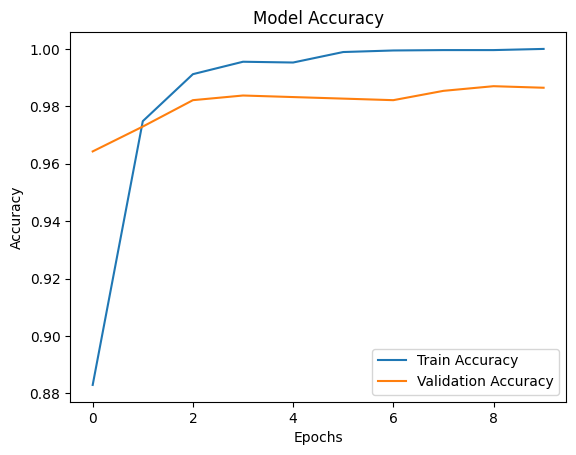

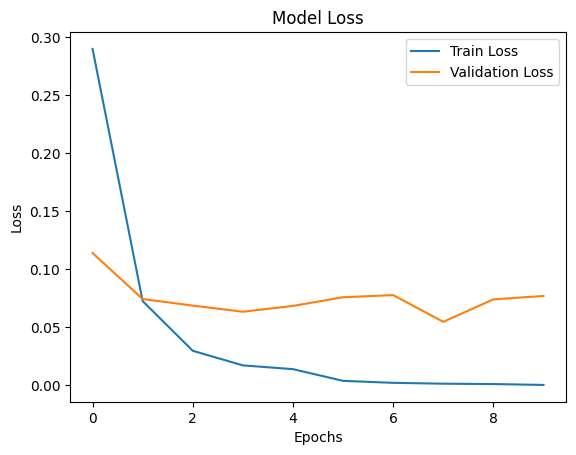

In [41]:
import matplotlib.pyplot as plt

# Plot accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Model Inference

In this step, you will use the trained model to make predictions on new, unseen data (inference). Here’s an outline of the key points:

1. **Create Test Sample**:
   Create a string to test your modelm the goal here is to give the model Before making predictions, ensure that the new data is preprocessed in the same way as the training data. This includes tokenization, padding, and any other transformations you applied during the data preprocessing step. The data can be single text to see the result of the prediction.

2. **Model Prediction**:
   Use the `predict()` method to feed new samples into the trained model and obtain predictions. The model will output probabilities or predicted class labels based on the type of classification task (binary or multi-class).

3. **Interpreting Predictions**:
   The model will return probabilities for each class.

In [47]:
# Example new text
new_text = "For fear of fainting with the of all that housework you just did? Quick have a cuppa"

# Tokenize the new text (same tokenizer used during training)
new_sequence = tokenizer.texts_to_sequences([new_text])

# Pad the sequence (same max_len used during training)
new_padded_sequence = pad_sequences(new_sequence, maxlen=max_len, padding='post')

print("Tokenized and padded new text:", new_padded_sequence)


Tokenized and padded new text: [[ 161 2191  391 4365  334   65  391  209  100 4366    5   60  172 1104
    91   88 4367    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]


In [46]:
# Use the trained model to make a prediction on the new padded sequence
prediction = model.predict(new_padded_sequence)

# Output the predicted probability
print(f"Predicted probability: {prediction[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted probability: 0.000739589799195528


In [45]:
# Interpret the prediction for binary classification
if prediction[0][0] > 0.5:
    print("The model predicts: HAM")
else:
    print("The model predicts: spam")


The model predicts: spam


# Notebook Question:
- How did you handle text preprocessing? Why did you choose this approach?
I handled it by inspecting the data and i notice the labels isn't balanced, which can cause errors to the models

- Why did you choose this model design?
i have training on data similar to this so i choosed this model design

- Why did you pick this number of layers or units for the model?
i tried before on similar data but it was in arabic and it gave me good results
- Why did you select these evaluation methods?
i used model to evaluate to check the results of my model

- Does your model show signs of overfitting or underfitting? How do you know?
yeah it sign of overfitting from the graph and the accuracy throught epochs
- What changes could you make to improve the model and fix overfitting or underfitting?
Balancing the data labels so it should be %50 %50, so model can give accurate result

Answer Here: